In [1]:
from dataloader import DataLoader, DataTransformer
from model import Model
from datetime import datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import backtrader as bt
import pyfolio as pf
%matplotlib inline

Using TensorFlow backend.


In [2]:
tickers = ['SPY']
from_date = datetime(2016, 1, 1)
to_date = datetime(2017, 11, 7)
entry_percentage = 0.6

In [3]:
loader = DataLoader(tickers, from_date=from_date, to_date=to_date)
loader.reload_all()

In [4]:
transformer = DataTransformer(loader)
transformer.transform()

In [5]:
model = Model(transformer)
model.build_model_data()
model.build_neural_net()

In [6]:
datetime(2016, 12, 31).strftime('%Y-%m-%d')

'2016-12-31'

In [7]:
model.predict_one('SPY', '2016-10-18')[0]

array([ 0.52124143,  0.47875857], dtype=float32)

In [8]:
class TestStrategy(bt.Strategy):

    def log(self, txt, dt=None):
        dt = dt or self.datas[0].datetime.date(0)
        print('%s, %s' % (dt.isoformat(), txt))

    def __init__(self):
        self.dataclose = self.datas[0].close
        self.order = None
        
    def notify_order(self, order):
        if order.status in [order.Submitted, order.Accepted]:
            return

        if order.status in [order.Completed]:
            if order.isbuy():
                self.log('BUY EXECUTED, %.2f' % order.executed.price)
            elif order.issell():
                self.log('SELL EXECUTED, %.2f' % order.executed.price)

            self.bar_executed = len(self)

        elif order.status in [order.Canceled, order.Margin, order.Rejected]:
            self.log('Order Canceled/Margin/Rejected')
        
        self.prev_order = self.order
        self.order = None

    def next(self):
        #self.log('Close, %.2f' % self.dataclose[0])
        
        if self.order:
            return
        
        if not self.position:
            try:
                today = self.datas[0].datetime.date(0).isoformat()
                prediction = model.predict_one('SPY', today)[0]
                if prediction[0] > entry_percentage:
                    self.order = self.buy()
                elif prediction[1] > entry_percentage:
                    self.order = self.sell()
            except Exception as e:
                self.log(e)
        else:
            if len(self) >= (self.bar_executed + 5):
                if self.prev_order.isbuy():
                    self.order = self.sell()
                else:
                    self.order = self.buy()

In [9]:
cerebro = bt.Cerebro()
cerebro.addstrategy(TestStrategy)

data = bt.feeds.YahooFinanceData(
    dataname='SPY',
    fromdate=from_date,
    todate=to_date,
    reverse=False)

cerebro.adddata(data)
cerebro.broker.setcash(100000.0)
cerebro.broker.setcommission(commission=0.001)
cerebro.addsizer(bt.sizers.PercentSizer, percents=20)

cerebro.addanalyzer(bt.analyzers.PyFolio, _name='pyfolio')

print('Starting Portfolio Value: %.2f' % cerebro.broker.getvalue())
results = cerebro.run()
print('Final Portfolio Value: %.2f' % cerebro.broker.getvalue())

strat = results[0]
pyfoliozer = strat.analyzers.getbyname('pyfolio')
returns, positions, transactions, gross_lev = pyfoliozer.get_pf_items()

Starting Portfolio Value: 100000.00
2016-01-04, 'the label [2016-01-04] is not in the [index]'
2016-01-05, 'the label [2016-01-05] is not in the [index]'
2016-01-06, 'the label [2016-01-06] is not in the [index]'
2016-01-07, 'the label [2016-01-07] is not in the [index]'
2016-01-08, 'the label [2016-01-08] is not in the [index]'
2016-01-11, 'the label [2016-01-11] is not in the [index]'
2016-01-12, 'the label [2016-01-12] is not in the [index]'
2016-01-13, 'the label [2016-01-13] is not in the [index]'
2016-01-14, 'the label [2016-01-14] is not in the [index]'
2016-01-15, 'the label [2016-01-15] is not in the [index]'
2016-01-19, 'the label [2016-01-19] is not in the [index]'
2016-01-20, 'the label [2016-01-20] is not in the [index]'
2016-01-21, 'the label [2016-01-21] is not in the [index]'
2016-01-22, 'the label [2016-01-22] is not in the [index]'
2016-01-25, 'the label [2016-01-25] is not in the [index]'
2016-01-26, 'the label [2016-01-26] is not in the [index]'
2016-01-27, 'the lab

Start date,2016-01-04
End date,2017-11-06
Total months,22
,Backtest
Annual return,0.9%
Cumulative returns,1.6%
Annual volatility,3.0%
Sharpe ratio,0.30
Calmar ratio,0.43
Stability,0.65
Max drawdown,-2.0%


c:\programdata\anaconda3\envs\trading3\lib\site-packages\numpy\core\fromnumeric.py:57: FutureWarning: 'argmin' is deprecated. Use 'idxmin' instead. The behavior of 'argmin' will be corrected to return the positional minimum in the future. Use 'series.values.argmin' to get the position of the minimum now.
  return getattr(obj, method)(*args, **kwds)


Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,2.00,2016-02-19,2016-03-10,2016-06-27,92
1,1.95,2016-06-27,2016-07-07,2017-01-26,154
2,1.08,2017-04-28,2017-08-18,NaT,NaN
3,0.61,2017-03-20,2017-04-19,2017-04-26,28
4,0.32,2017-02-24,2017-02-28,2017-03-07,8


c:\programdata\anaconda3\envs\trading3\lib\site-packages\pyfolio\timeseries.py:600: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  factor_returns_period = factor_returns.loc[returns_period.index]
c:\programdata\anaconda3\envs\trading3\lib\site-packages\numpy\core\fromnumeric.py:57: FutureWarning: 'argmin' is deprecated. Use 'idxmin' instead. The behavior of 'argmin' will be corrected to return the positional minimum in the future. Use 'series.values.argmin' to get the position of the minimum now.
  return getattr(obj, method)(*args, **kwds)


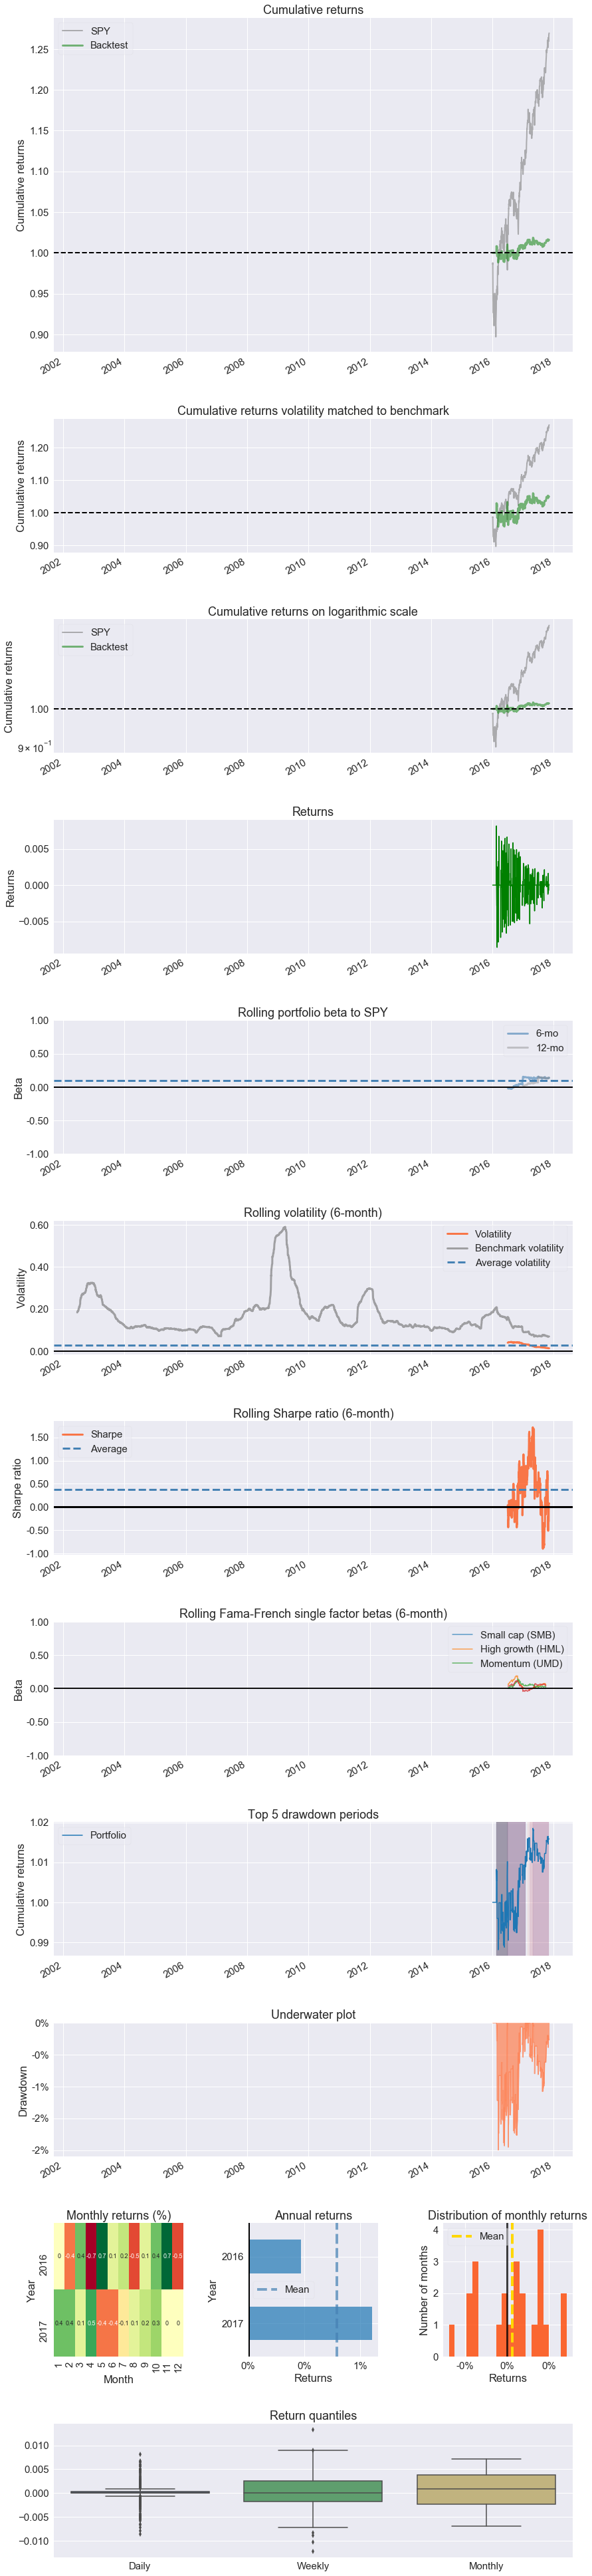

Stress Events,mean,min,max
New Normal,0.00%,-0.86%,0.82%


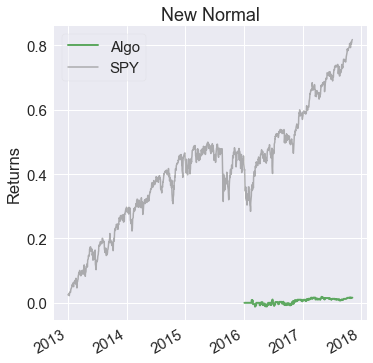

Top 10 long positions of all time,max
SPY,20.71%


Top 10 short positions of all time,max
SPY,-20.18%


Top 10 positions of all time,max
SPY,20.71%


All positions ever held,max
SPY,20.71%


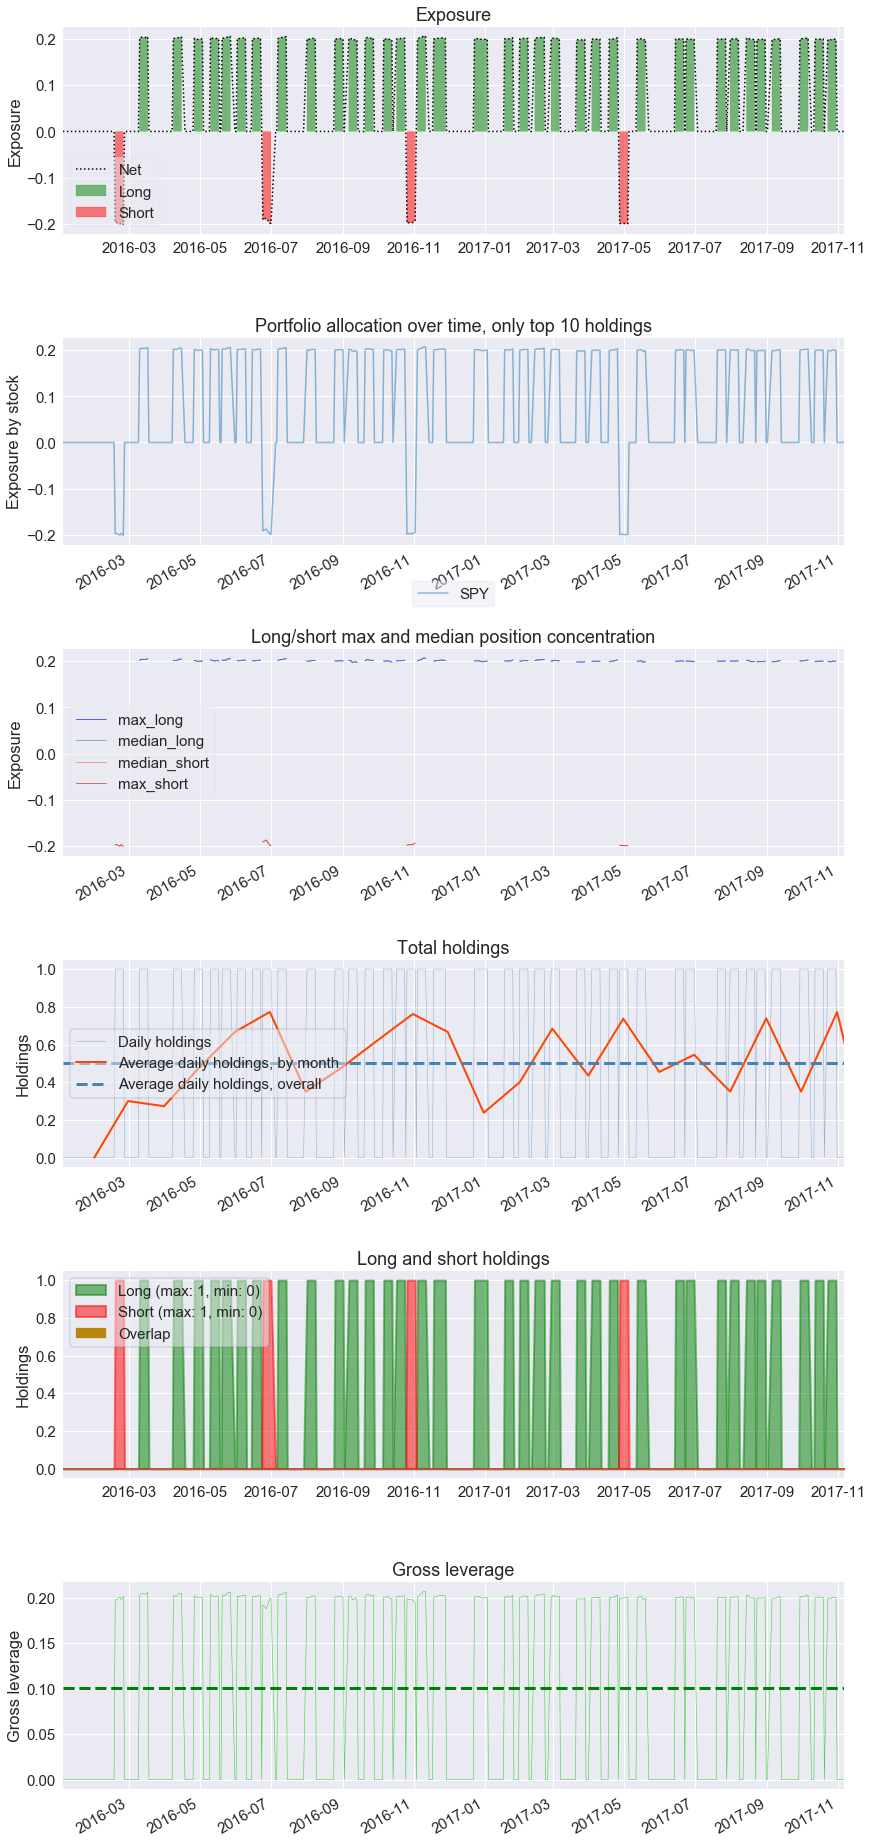

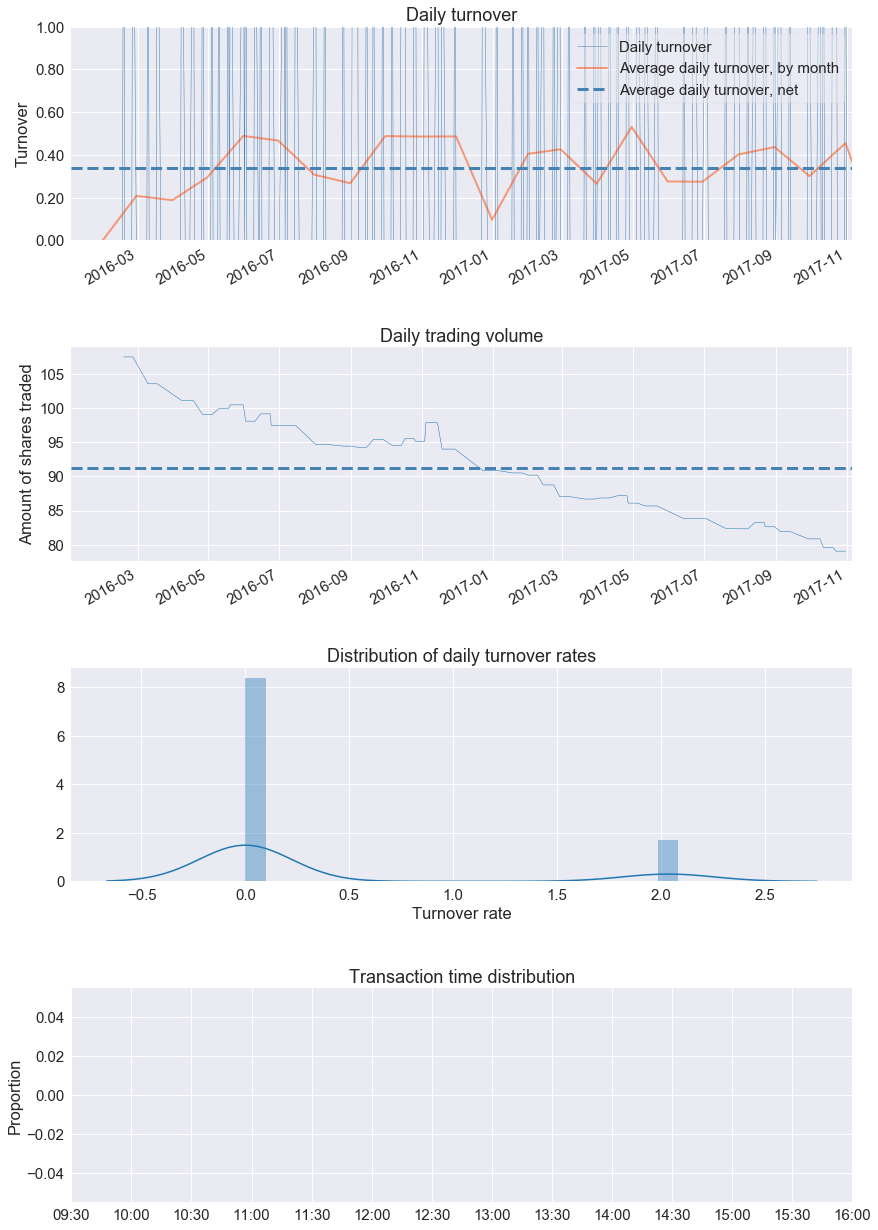

c:\programdata\anaconda3\envs\trading3\lib\site-packages\pyfolio\round_trips.py:80: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  .agg(stats_dict)
c:\programdata\anaconda3\envs\trading3\lib\site-packages\pyfolio\round_trips.py:83: FutureWarning: Using 'rename_axis' to alter labels is deprecated. Use '.rename' instead
  axis='columns'))
c:\programdata\anaconda3\envs\trading3\lib\site-packages\pyfolio\round_trips.py:86: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  .agg(stats_dict)
c:\programdata\anaconda3\envs\trading3\lib\site-packages\pyfolio\round_trips.py:90: FutureWarning: Using 'rename_axis' to alter labels is deprecated. Use '.rename' instead
  axis='columns'))
c:\programdata\anaconda3\envs\trading3\lib\site-packages\pyfolio\round_trips.py:379: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future versi

Summary stats,All trades,Short trades,Long trades
Total number of round_trips,39.00,4.00,35.00
Percent profitable,0.62,0.25,0.66
Winning round_trips,24.00,1.00,23.00
Losing round_trips,15.00,3.00,12.00
Even round_trips,0.00,0.00,0.00


PnL stats,All trades,Short trades,Long trades
Total profit,$3165.40,$-606.85,$3772.25
Gross profit,$6038.08,$305.90,$5732.18
Gross loss,$-2872.68,$-912.75,$-1959.93
Profit factor,$2.10,$0.34,$2.92
Avg. trade net profit,$81.16,$-151.71,$107.78
Avg. winning trade,$251.59,$305.90,$249.23
Avg. losing trade,$-191.51,$-304.25,$-163.33
Ratio Avg. Win:Avg. Loss,$1.31,$1.01,$1.53
Largest winning trade,$787.64,$305.90,$787.64
Largest losing trade,$-516.04,$-516.04,$-508.54


Duration stats,All trades,Short trades,Long trades
Avg duration,8 days 14:46:09.230769,8 days 18:00:00,8 days 14:24:00
Median duration,8 days 00:00:00,8 days 00:00:00,8 days 00:00:00
Longest duration,12 days 00:00:00,11 days 00:00:00,12 days 00:00:00
Shortest duration,8 days 00:00:00,8 days 00:00:00,8 days 00:00:00


Return stats,All trades,Short trades,Long trades
Avg returns all round_trips,nan%,nan%,nan%
Avg returns winning,nan%,nan%,nan%
Avg returns losing,nan%,nan%,nan%
Median returns all round_trips,nan%,nan%,nan%
Median returns winning,nan%,nan%,nan%
Median returns losing,nan%,nan%,nan%
Largest winning trade,nan%,nan%,nan%
Largest losing trade,nan%,nan%,nan%


Symbol stats,SPY
Avg returns all round_trips,nan%
Avg returns winning,nan%
Avg returns losing,nan%
Median returns all round_trips,nan%
Median returns winning,nan%
Median returns losing,nan%
Largest winning trade,nan%
Largest losing trade,nan%


Profitability (PnL / PnL total) per name,
symbol,
SPY,100.00%


c:\programdata\anaconda3\envs\trading3\lib\site-packages\seaborn\distributions.py:195: RuntimeWarning: Mean of empty slice.
  line, = ax.plot(a.mean(), 0)
c:\programdata\anaconda3\envs\trading3\lib\site-packages\numpy\core\_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


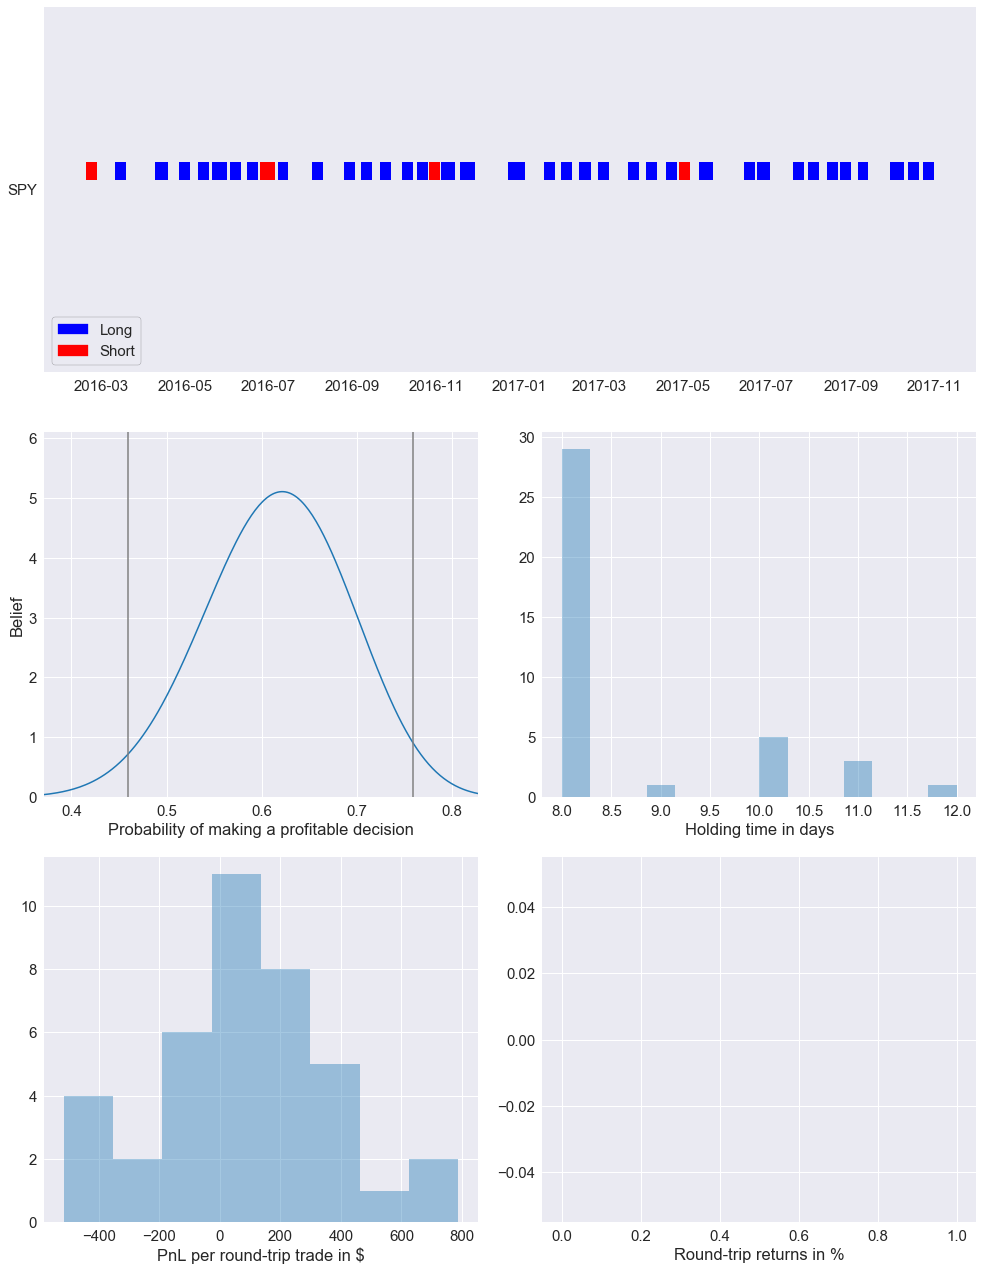

In [10]:
pf.create_full_tear_sheet(returns=returns, 
                          positions=positions, 
                          transactions=transactions, 
                          round_trips=True)

Start date,2016-01-04
End date,2017-11-06
Total months,22
,Backtest
Annual return,0.9%
Cumulative returns,1.6%
Annual volatility,3.0%
Sharpe ratio,0.30
Calmar ratio,0.43
Stability,0.65
Max drawdown,-2.0%


c:\programdata\anaconda3\envs\trading3\lib\site-packages\numpy\core\fromnumeric.py:57: FutureWarning: 'argmin' is deprecated. Use 'idxmin' instead. The behavior of 'argmin' will be corrected to return the positional minimum in the future. Use 'series.values.argmin' to get the position of the minimum now.
  return getattr(obj, method)(*args, **kwds)


Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,2.00,2016-02-19,2016-03-10,2016-06-27,92
1,1.95,2016-06-27,2016-07-07,2017-01-26,154
2,1.08,2017-04-28,2017-08-18,NaT,NaN
3,0.61,2017-03-20,2017-04-19,2017-04-26,28
4,0.32,2017-02-24,2017-02-28,2017-03-07,8


c:\programdata\anaconda3\envs\trading3\lib\site-packages\pyfolio\timeseries.py:600: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  factor_returns_period = factor_returns.loc[returns_period.index]


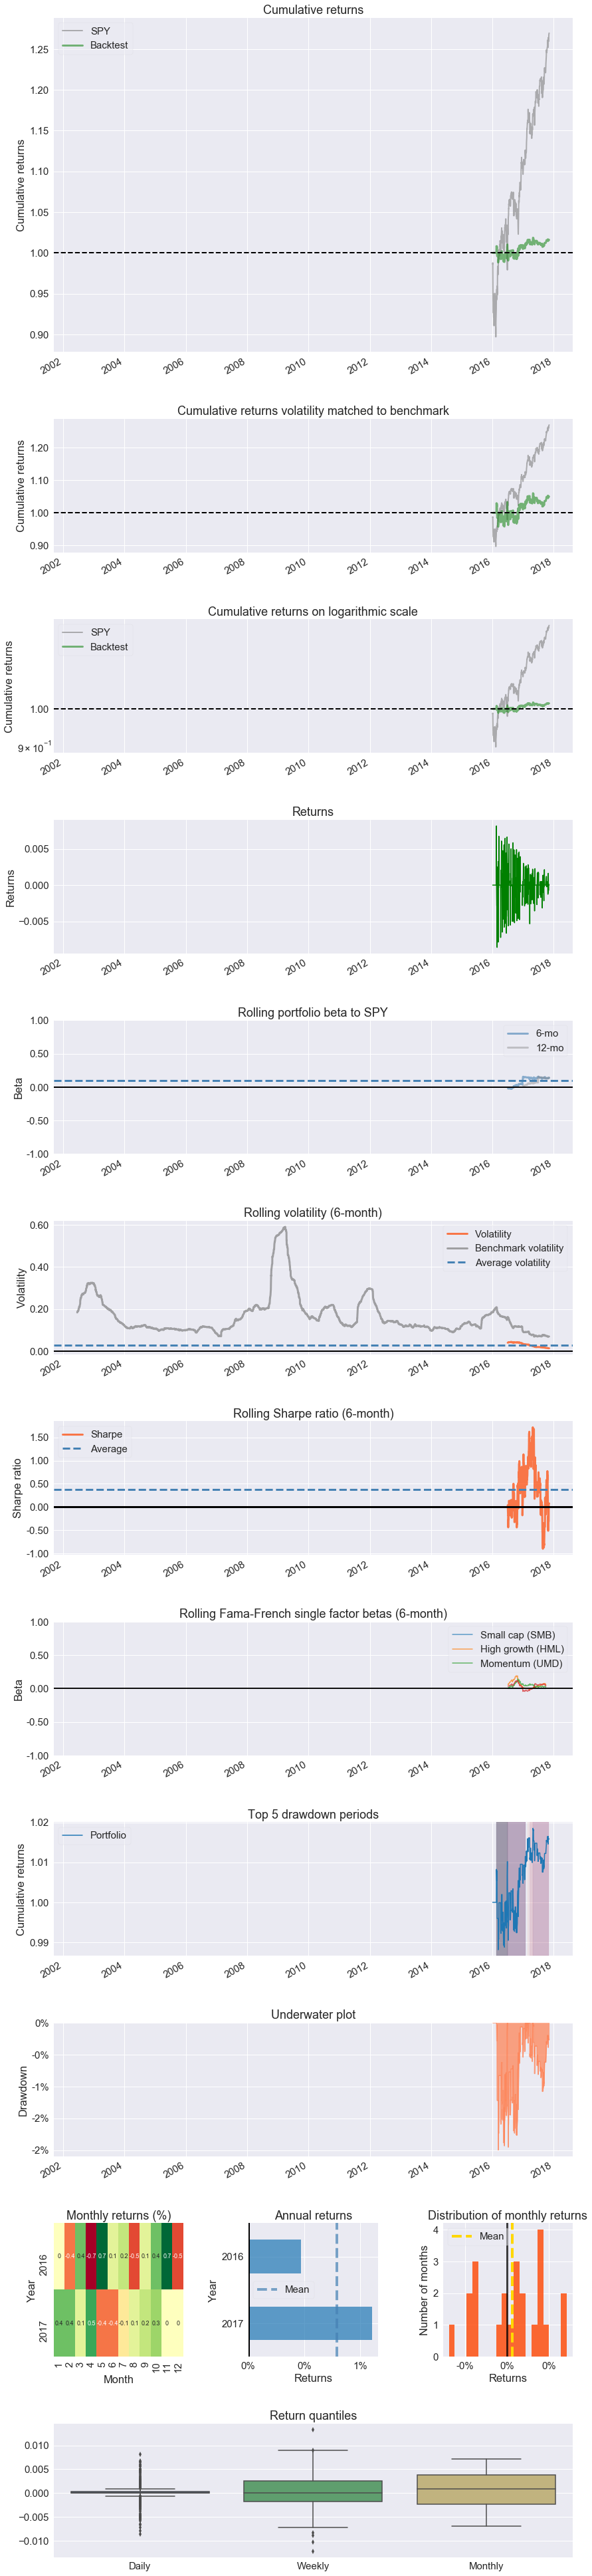

In [14]:
pf.create_returns_tear_sheet(
    returns,
    positions=positions,
    transactions=transactions)

Top 10 long positions of all time,max
SPY,20.71%


Top 10 short positions of all time,max
SPY,-20.18%


Top 10 positions of all time,max
SPY,20.71%


All positions ever held,max
SPY,20.71%


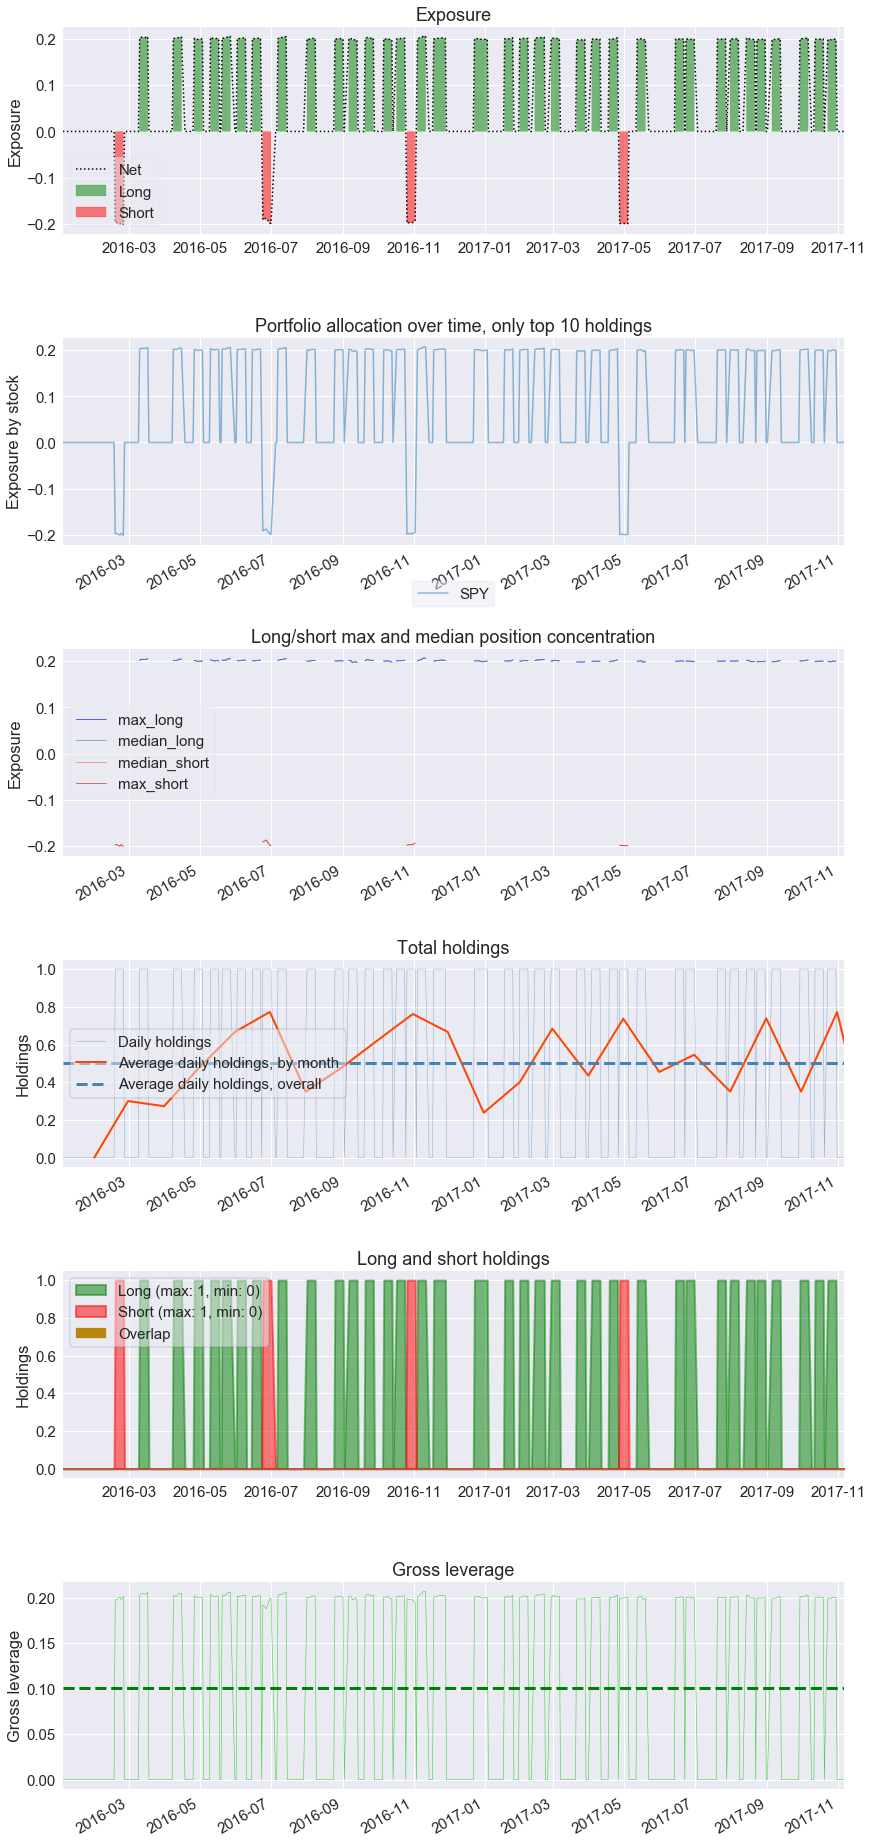

In [12]:
pf.create_position_tear_sheet(returns,
    positions=positions,
    transactions=transactions)

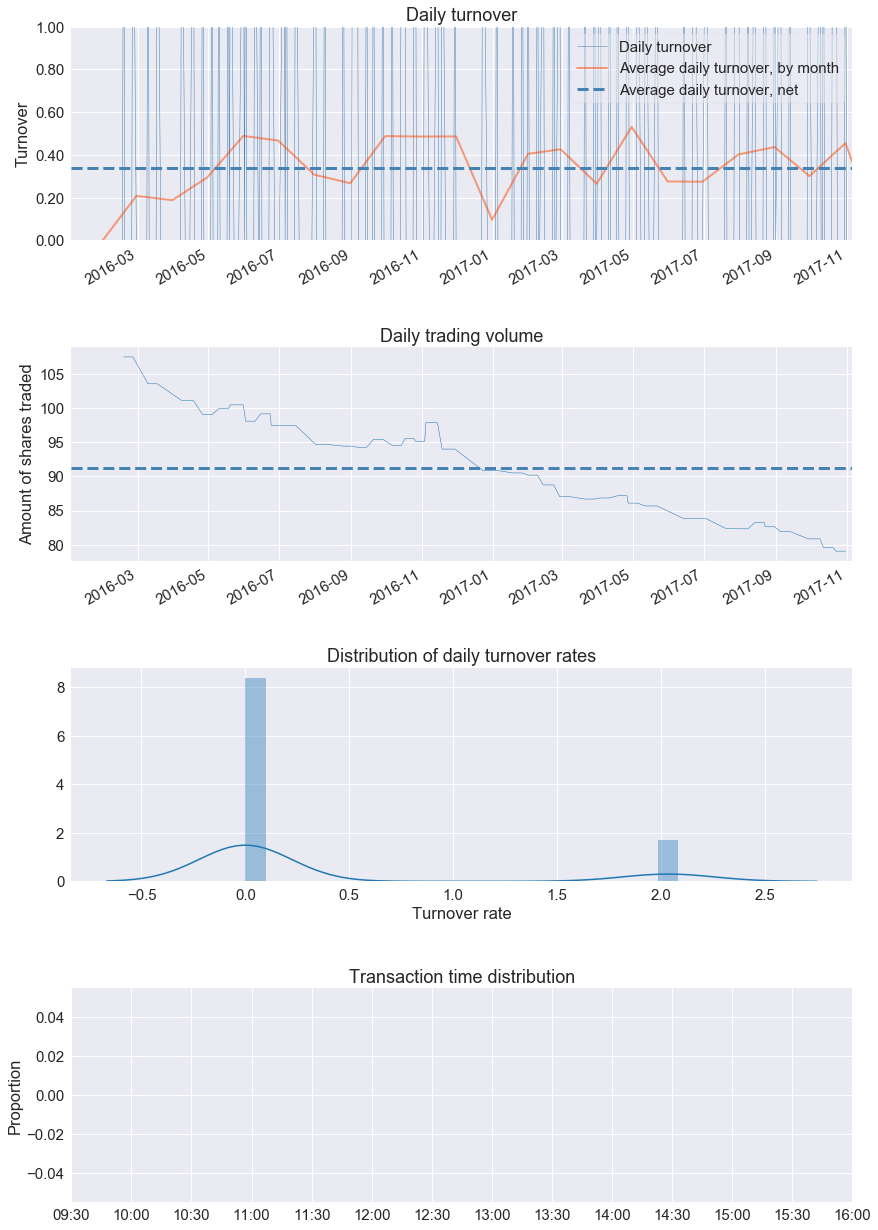

In [13]:
pf.create_txn_tear_sheet(returns, positions, transactions)